# Facial Recognition with TensorFlow

## Unsupervised Learing   scribbles

### About the Dataset
A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).

### Purpose of this Notebook

The goal of this notebook is to create a n

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import keras as ks
from skimage import io
import os
import csv

C:\Users\etallen127\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
attr = pd.read_csv('list_attr_celeba.csv')

In [3]:
hair = pd.DataFrame(np.where(attr > 0, 1, 0),columns=['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'])

In [4]:
hair.drop(['image_id'], axis=1,inplace=True)

In [5]:
hair = hair[(hair.T != 0).any()]

In [6]:
target_images = hair.index

In [7]:
# Importing cv2 to help work with images
import cv2

# Creating a function to format images
def load_images(path):
    img_data = [] # return the image itself
    index = [] # adds an index to reference image
    x = -1
    for pic in os.listdir(path):
        pic_path = os.path.join(path,pic)
        for img in os.listdir(pic_path):
            x += 1
            if x in target_images:
                img_path = os.path.join(pic_path,img)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (64, 64))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                img_data.append(image)
                index.append(x)
    return(np.array(img_data),np.array(index))

In [8]:
# Setting up fill location for our load_images function
train_path = 'images'

In [9]:
(X, img_num) = load_images(train_path)

In [10]:
i = X[0:40000]

In [11]:
j = i.reshape((i.shape[0], -1))
j = np.divide(j, 255.)

In [12]:
# Importing Modeling Tools
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from sklearn.cluster import KMeans
from keras.optimizers import RMSprop
from sklearn.cross_validation import train_test_split

C:\Users\etallen127\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans

In [14]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [15]:
dims = [j.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 6
batch_size = 32

In [16]:
autoencoder, encoder = autoencoder(dims, init=init)

In [17]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(j, j, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)

Epoch 1/6
40000/40000 [==============================] - 276s 7ms/step - loss: nan
Epoch 2/6
40000/40000 [==============================] - 266s 7ms/step - loss: nan
Epoch 3/6
40000/40000 [==============================] - 264s 7ms/step - loss: nan
Epoch 4/6
40000/40000 [==============================] - 269s 7ms/step - loss: nan
Epoch 5/6
40000/40000 [==============================] - 264s 7ms/step - loss: nan
Epoch 6/6
40000/40000 [==============================] - 265s 7ms/step - loss: nan


In [18]:
kmeans = KMeans(n_clusters=10, n_init=10,n_jobs=8)
y_pred = kmeans.fit_predict(encoder.predict(j))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
y_pred[0:10]

In [21]:
i.shape

(40000, 64, 64, 3)

In [23]:
df = hair[0:40000]

In [31]:
df['group'] = (y_pred + 1)

C:\Users\etallen127\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
df.to_csv('40k_grouped.csv')

In [34]:
a = pd.read_csv('40k_grouped.csv')

In [35]:
a.head()

,Unnamed: 0,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,group
0,0,0,1,1,0,0,0,0,0,0,...,1,1,0,1,0,1,0,0,1,1
1,1,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,3
2,2,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,7
3,3,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,1,8
4,4,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,4


In [36]:
group_one = a[a['group'] == 1]

In [37]:
target_images = group_one.index

In [38]:
# Importing cv2 to help work with images
import cv2

# Creating a function to format images
def load_images(path):
    img_data = [] # return the image itself
    index = [] # adds an index to reference image
    x = -1
    for pic in os.listdir(path):
        pic_path = os.path.join(path,pic)
        for img in os.listdir(pic_path):
            x += 1
            if x in target_images:
                img_path = os.path.join(pic_path,img)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (64, 64))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                img_data.append(image)
                index.append(x)
    return(np.array(img_data),np.array(index))

In [39]:
# Setting up fill location for our load_images function
train_path = 'images'

In [40]:
(X, img_num) = load_images(train_path)

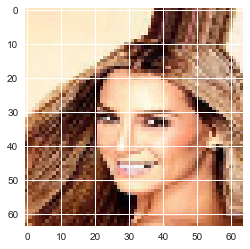

In [60]:
plt.imshow(X[0],interpolation='nearest')

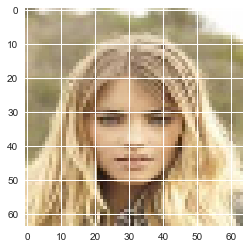

In [61]:
plt.imshow(X[2],interpolation='nearest')
plt.show()

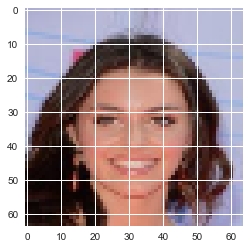

In [62]:
plt.imshow(X[3],interpolation='nearest')
plt.show()

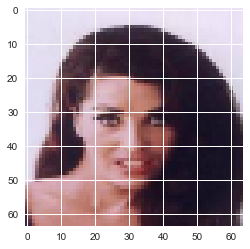

In [63]:
plt.imshow(X[1],interpolation='nearest')
plt.show()

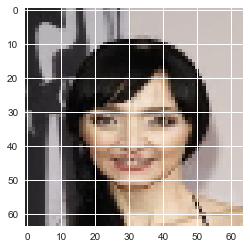

In [64]:
plt.imshow(X[4],interpolation='nearest')
plt.show()

In [66]:
group_one['Male'].value_counts()

0    2400
1    1361
Name: Male, dtype: int64

In [69]:
group_one.describe()

,Unnamed: 0,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,group
count,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,...,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.00000,3761.000000,3761.0
mean,20255.561819,0.092263,0.291146,0.568200,0.187450,0.021803,0.169370,0.242755,0.205530,0.221750,...,0.501994,0.202606,0.356022,0.196490,0.053443,0.524329,0.130816,0.06461,0.797660,1.0
std,11569.547097,0.289435,0.454351,0.495393,0.390324,0.146058,0.375128,0.428805,0.404142,0.415479,...,0.500063,0.401995,0.478886,0.397396,0.224946,0.499474,0.337244,0.24587,0.401798,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.0
25%,10182.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.0
50%,20428.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,1.0
75%,30297.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.00000,1.000000,1.0
max,39991.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.0


In [70]:
3761 * 0.092263 

347.001143

In [71]:
group_one['5_o_Clock_Shadow'].value_counts()

0    3414
1     347
Name: 5_o_Clock_Shadow, dtype: int64